# Movie Recommendation System

 I have used https://www.kaggle.com/tmdb/tmdb-movie-metadata for building recommendation systems.

There are three types of recommender systems :-
 
1. Demographic Filtering - It uses the demographic data of a user to determine which items may be appropriate for recommendation.

2. Content Based Filtering - It uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback.

3. Collaborative Filtering - This system matches persons with similar interests and provides recommendations based on this matching. Collaborative filters do not require item metadata like its content-based counterparts. 

## Importing libraries and loading data

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from ast import literal_eval
d1=pd.read_csv('tmdb_5000_credits.csv')
d2=pd.read_csv('tmdb_5000_movies.csv')

### Merging d1 & d2

In [178]:
d1.columns = ['id','title','cast','crew']
d2 = d2.merge(d1,on='id')

In [179]:
d2.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


## Demographic Filtering

Before getting started with this -

1. we need a metric to score or rate movie
2. Calculate the score for every movie
3. Sort the scores and recommend the best rated movie to the users.

We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes. So, I'll be using IMDB's weighted rating (wr) which is given as :-

![alt text](wr.png "")

where,

1. v is the number of votes for the movie;
2. m is the minimum votes required to be listed in the chart;
3. R is the average rating of the movie; And
4. C is the mean vote across the whole report

We already have v(vote_count) and R (vote_average) and C can be calculated as

In [180]:
C= d2['vote_average'].mean()
C

6.092171559442011

### Calculating m, we use 90% percentile as cutoff. It must have more votes than at least 90% of the movies in the list.

In [181]:
m= d2['vote_count'].quantile(0.9)
m

1838.4000000000015

### Qualified movies

In [182]:
q_movies = d2.copy().loc[d2['vote_count'] >= m]
q_movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [213]:
q_movies.shape

(481, 24)

### Calculate our metric for each qualified movie using function w_rating

In [183]:
def w_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [184]:
# Define a new feature 'score' and calculate its value with `w_rating()`
q_movies['score'] = q_movies.apply(w_rating, axis=1)

In [185]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title_x', 'vote_count', 'vote_average', 'score']].head(10)

,title_x,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


### This recommendation system shows the ' Trending Now '  tab of a streaming app

Text(0.5, 1.0, 'Popular Movies')

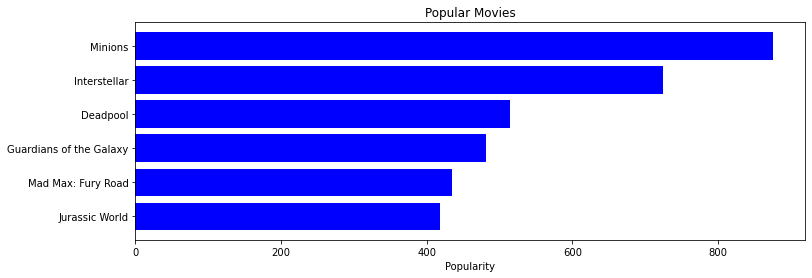

In [186]:
pop= d2.sort_values('popularity', ascending=False)

plt.figure(figsize=(12,4))
plt.barh(pop['title_x'].head(6),pop['popularity'].head(6), align='center',color='blue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

## Content Based Filtering

### 1. Plot description based Recommender

We are going use Plot description based Recommender for all movies  based on their similarity score.

In [187]:
d2['overview'].head()

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

### TfIdfVectorizer

We'll use Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.

This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction.

![alt text](tfidf.png "")

In [188]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
d2['overview'] = d2['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(d2['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

### Using linear_kernal()

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:

![alt text](simi.png "")

In [189]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

### Function that takes in a movie title as an input and outputs a list of the 10 most similar movies. 

In [190]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(d2.index, index=d2['title_x']).drop_duplicates()

In [191]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return d2['title_x'].iloc[movie_indices]

In [192]:
get_recommendations('The Godfather')

2731     The Godfather: Part II
1873                 Blood Ties
867     The Godfather: Part III
3727                 Easy Money
3623                       Made
3125                     Eulogy
3896                   Sinister
4506            The Maid's Room
3783                        Joe
2244      The Cold Light of Day
Name: title_x, dtype: object

In [193]:
get_recommendations('Inception')

2897                                Cypher
134     Mission: Impossible - Rogue Nation
1930                            Stone Cold
914                   Central Intelligence
1683                       Pitch Perfect 2
1248                        At First Sight
1512                 A History of Violence
2389                           Renaissance
1803                        Blood and Wine
1267                                Duplex
Name: title_x, dtype: object

### 2. Credits, Genres and Keywords Based Recommender

We are going to build a recommender based on the following metadata: the 3 top actors, the director, related genres and the movie plot keywords. This system quality will incraese because of better usage of data.

In [194]:
features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    d2[feature] = d2[feature].apply(literal_eval)

In [195]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [196]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [197]:
# Define new director, cast, genres and keywords features that are in a suitable form.
d2['director'] = d2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    d2[feature] = d2[feature].apply(get_list)

In [198]:
d2[['title_x', 'cast', 'director', 'keywords', 'genres']].head(2)

,title_x,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"


In [199]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [200]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    d2[feature] = d2[feature].apply(clean_data)

We are now in a position to create our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer

In [201]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
d2['soup'] = d2.apply(create_soup, axis=1)

### Using CountVectorizer

It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text.

In [202]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(d2['soup'])

In [203]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [204]:
# Reset index of our main DataFrame and construct reverse mapping as before
d2 = d2.reset_index()
indices = pd.Series(d2.index, index=d2['title_x'])

In [207]:
get_recommendations('Batman Begins', cosine_sim2)

3          The Dark Knight Rises
65               The Dark Knight
4638    Amidst the Devil's Wings
1196                The Prestige
1742              Brick Mansions
3603           Lone Wolf McQuade
982                Run All Night
3326              Black November
1503                      Takers
1986                      Faster
Name: title_x, dtype: object

In [209]:
get_recommendations('The Avengers', cosine_sim2)

7                  Avengers: Age of Ultron
26              Captain America: Civil War
79                              Iron Man 2
169     Captain America: The First Avenger
174                    The Incredible Hulk
85     Captain America: The Winter Soldier
31                              Iron Man 3
33                   X-Men: The Last Stand
68                                Iron Man
94                 Guardians of the Galaxy
Name: title_x, dtype: object

This reccomendation sysytem has better success rate more than others because of utilizing more information from all the metadata. It gives us a better recommendations.

It is more likely that Marvels or DC comics fans will like the movies of the same production house. Therefore, to our features above we can add production_company . We can also increase the weight of the director , by adding the feature multiple times in the soup.

## Collaborative Filtering

### User based filtering

These systems recommend products to a user that similar users have liked. For measuring the similarity between two users we can either use pearson correlation or cosine similarity. 

### Item Based Collaborative Filtering 

Instead of measuring the similarity between users, the item-based CF recommends items based on their similarity with the items that the target user rated. Likewise, the similarity can be computed with Pearson Correlation or Cosine Similarity.

### I have not done this one in this following notebook. Feel free to explore on your own

# Conclusion
I have create recommendation systems using demographic and content- based. While demographic filtering is very simple and elementary and cannot be used practically whereas Hybrid Systems can take advantage of content-based and collaborative filtering as the two approaches are proved to be almost complimentary. This model was very baseline and only provides a fundamental framework and information to start with.